In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

In [25]:
p_karst_with_controls = gpd.read_file('p_karst_controls_and_slope_5070.shp')
#p_karst_with_controls = gpd.read_file("p_karst_with_controls_5070.shp")
p_karst_with_controls.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29068 entries, 0 to 29067
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    29068 non-null  float64 
 1   tnmid       29068 non-null  object  
 2   metasource  11319 non-null  object  
 3   sourcedata  655 non-null    object  
 4   sourceorig  675 non-null    object  
 5   sourcefeat  0 non-null      object  
 6   loaddate    29011 non-null  object  
 7   referenceg  174 non-null    object  
 8   areaacres   29068 non-null  float64 
 9   areasqkm    29068 non-null  float64 
 10  states      29068 non-null  object  
 11  huc12       29068 non-null  object  
 12  name        29068 non-null  object  
 13  hutype      29068 non-null  object  
 14  humod       29060 non-null  object  
 15  tohuc       29068 non-null  object  
 16  noncontrib  27978 non-null  float64 
 17  noncontr_1  27898 non-null  float64 
 18  globalid    29068 non-null  object  
 

In [26]:
p_karst_with_controls_nonzero = p_karst_with_controls[p_karst_with_controls.p_karst>0]
p_karst_with_controls_nonzero.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5511 entries, 11 to 29050
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    5511 non-null   float64 
 1   tnmid       5511 non-null   object  
 2   metasource  2151 non-null   object  
 3   sourcedata  119 non-null    object  
 4   sourceorig  118 non-null    object  
 5   sourcefeat  0 non-null      object  
 6   loaddate    5511 non-null   object  
 7   referenceg  8 non-null      object  
 8   areaacres   5511 non-null   float64 
 9   areasqkm    5511 non-null   float64 
 10  states      5511 non-null   object  
 11  huc12       5511 non-null   object  
 12  name        5511 non-null   object  
 13  hutype      5511 non-null   object  
 14  humod       5510 non-null   object  
 15  tohuc       5511 non-null   object  
 16  noncontrib  5153 non-null   float64 
 17  noncontr_1  5149 non-null   float64 
 18  globalid    5511 non-null   object  
 19  s

In [27]:
common_rocks = ['limestone', 'dolostone (dolomite)', 'shale', 'sandstone']
p_karst_with_controls_nonzero = p_karst_with_controls_nonzero[p_karst_with_controls_nonzero.rocktype1.isin(common_rocks)]
p_karst_with_controls_nonzero.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3322 entries, 15 to 29050
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    3322 non-null   float64 
 1   tnmid       3322 non-null   object  
 2   metasource  1304 non-null   object  
 3   sourcedata  86 non-null     object  
 4   sourceorig  84 non-null     object  
 5   sourcefeat  0 non-null      object  
 6   loaddate    3322 non-null   object  
 7   referenceg  5 non-null      object  
 8   areaacres   3322 non-null   float64 
 9   areasqkm    3322 non-null   float64 
 10  states      3322 non-null   object  
 11  huc12       3322 non-null   object  
 12  name        3322 non-null   object  
 13  hutype      3322 non-null   object  
 14  humod       3321 non-null   object  
 15  tohuc       3322 non-null   object  
 16  noncontrib  3159 non-null   float64 
 17  noncontr_1  3156 non-null   float64 
 18  globalid    3322 non-null   object  
 19  s

In [28]:
p_karst_with_controls_nonzero.rocktype1.unique()

array(['dolostone (dolomite)', 'shale', 'limestone', 'sandstone'],
      dtype=object)

In [29]:
p_karst_with_controls_nonzero.keys()

Index(['objectid', 'tnmid', 'metasource', 'sourcedata', 'sourceorig',
       'sourcefeat', 'loaddate', 'referenceg', 'areaacres', 'areasqkm',
       'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc', 'noncontrib',
       'noncontr_1', 'globalid', 'shape_Leng', 'shape_Area', 'p_karst',
       'mean annua', 'mean diurn', 'isothermal', 'annual pre', 'precipitat',
       'net primar', 'monthly me', 'cmi mean', 'carbonate', 'clay', 'density',
       'ksat', 'organic ma', 'ph', 'depth res', 'rock fragm', 'sand', 'silt',
       'depth', 'water stor', 'exposure', 'induration', 'percent_ar',
       'rocktype1', 'rocktype2', 'unit_age', 'unit_name', 'median_slo',
       'geometry'],
      dtype='object')

Select factors and prediction variable and create categories

In [32]:
XY = p_karst_with_controls_nonzero.loc[:,['exposure', 'induration', 'rocktype1',
       'mean annua', 'mean diurn',
       'isothermal', 'annual pre',
       'precipitat', 'net primar',
       'monthly me', 'cmi mean', 'carbonate', 'clay', 'density', 'ksat',
       'organic ma', 'ph', 'depth res', 'rock fragm', 'sand', 'silt',
       'depth', 'water stor', 'p_karst', 'median_slo']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['exposure', 'induration', 'rocktype1',
       'mean annua', 'mean diurn',
       'isothermal', 'annual pre',
       'precipitat', 'net primar',
       'monthly me', 'cmi mean', 'carbonate', 'clay', 'density', 'ksat',
       'organic ma', 'ph', 'depth res', 'rock fragm', 'sand', 'silt',
       'depth', 'water stor', 'median_slo']]
Y = XY.p_karst
X['rocktype1'] = X['rocktype1'].astype('category')
X['exposure'] = X['exposure'].astype('category')
X['induration'] = X['induration'].astype('category')

#log transform slope
X['log_slope'] = np.log10(X['median_slo'])
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3207 entries, 15 to 29050
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   exposure    3207 non-null   category
 1   induration  3207 non-null   category
 2   rocktype1   3207 non-null   category
 3   mean annua  3207 non-null   float64 
 4   mean diurn  3207 non-null   float64 
 5   isothermal  3207 non-null   float64 
 6   annual pre  3207 non-null   float64 
 7   precipitat  3207 non-null   float64 
 8   net primar  3207 non-null   float64 
 9   monthly me  3207 non-null   float64 
 10  cmi mean    3207 non-null   float64 
 11  carbonate   3207 non-null   float64 
 12  clay        3207 non-null   float64 
 13  density     3207 non-null   float64 
 14  ksat        3207 non-null   float64 
 15  organic ma  3207 non-null   float64 
 16  ph          3207 non-null   float64 
 17  depth res   3207 non-null   float64 
 18  rock fragm  3207 non-null   float64 
 19  sand     

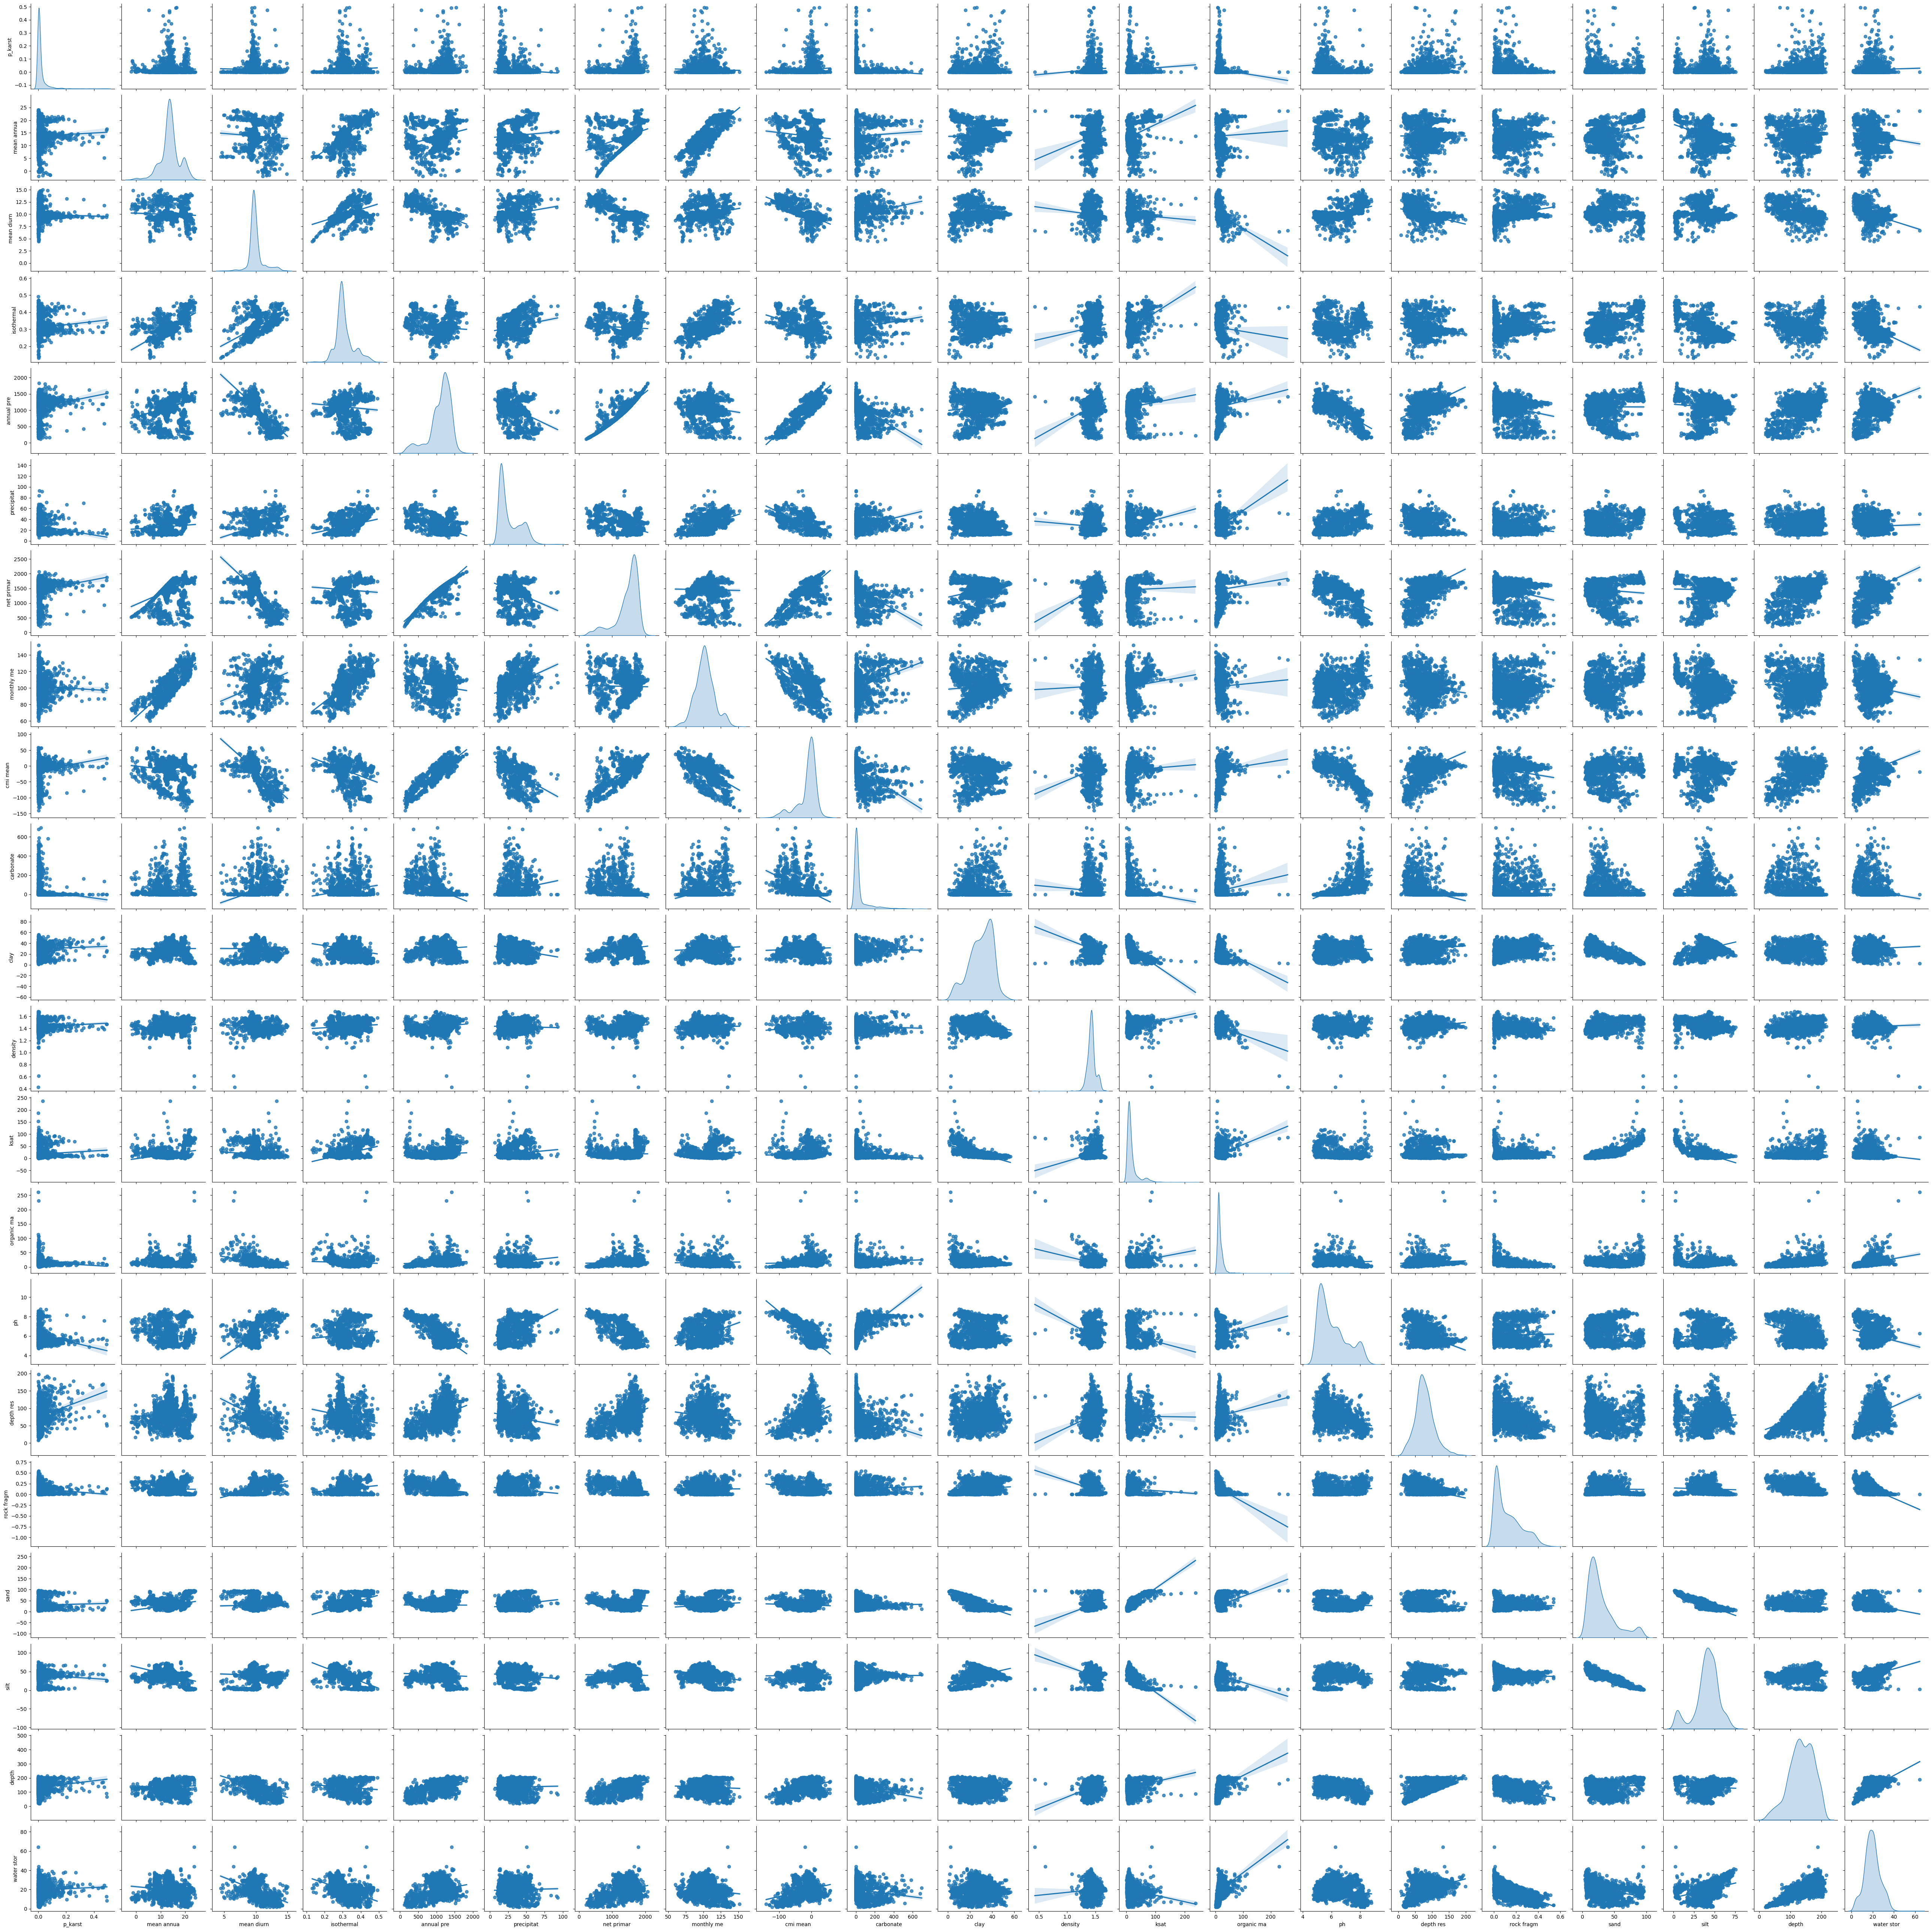

In [266]:
train_dataset = X_train.copy()
train_dataset.insert(0,"p_karst", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [34]:
#categorical_columns = ["exposure", "rocktype1", "induration"]
categorical_columns = ["exposure", "rocktype1", ]

"""
numerical_columns = ['mean annua', 'mean diurn',
       'isothermal', 'annual pre', 'precipitat', 'net primar', 'monthly me',
       'cmi mean', 'carbonate', 'clay', 'density', 'ksat', 'organic ma', 'ph',
       'depth res', 'rock fragm', 'sand', 'silt', 'depth', 'water stor']
"""

numerical_columns = ['mean annua', 'annual pre', 'precipitat',  
              'clay', 'sand', 'log_slope']

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)
alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas), func=np.log10, inverse_func=sp.special.exp10
    ),
)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['exposure', 'rocktype1']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['mean annua', 'annual pre',
                                                   'precipitat', 'clay', 'sand',
                                                   'log_slope'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

In [35]:
model[-1].regressor_.alpha_

10.0

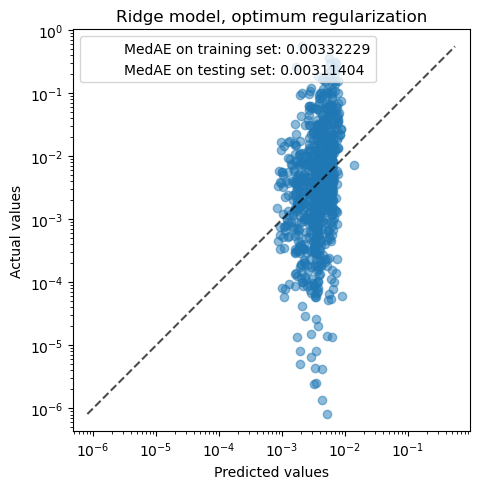

In [36]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.8f}",
    "MedAE on testing set": f"{mae_test:.8f} ",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5},
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Ridge model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

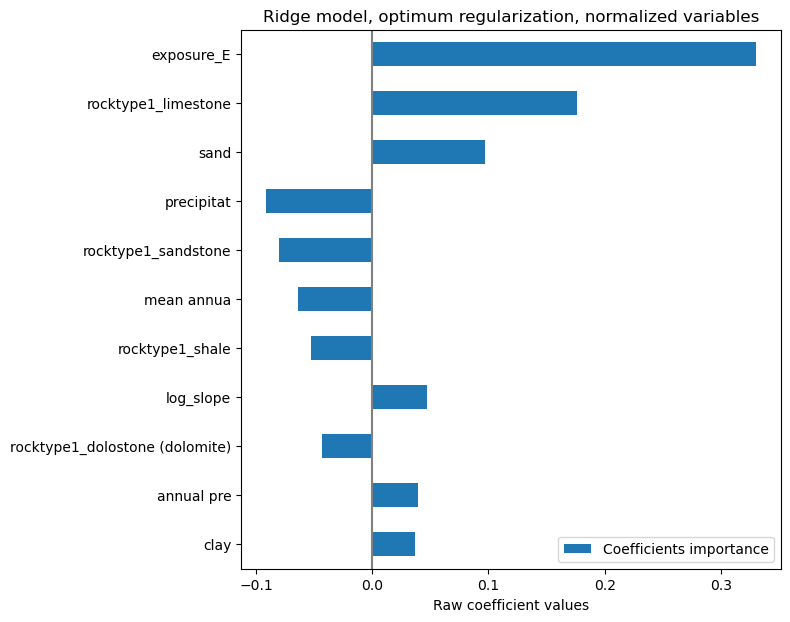

In [37]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.sort_values(by='Coefficients importance', key=np.abs, inplace=True)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, optimum regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [38]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

cv_model = cross_validate(
    model,
    X,
    Y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

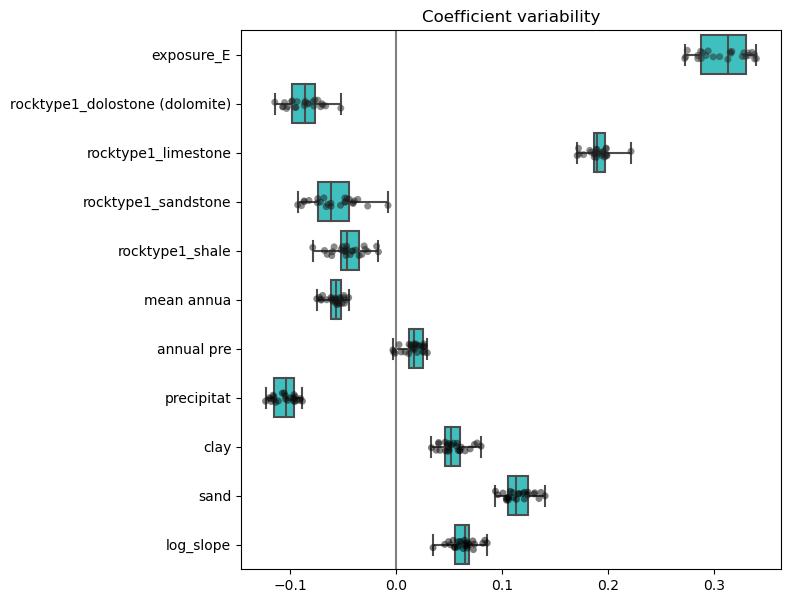

In [39]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

In [40]:
alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

_ = model.fit(X_train, y_train)

In [41]:
model[-1].regressor_.alpha_

0.0001

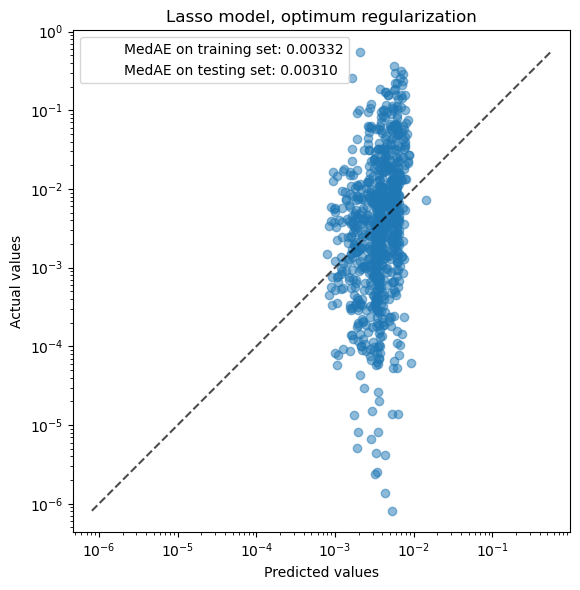

In [42]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.5f}",
    "MedAE on testing set": f"{mae_test:.5f}",
}

_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
ax.set_xscale('log')
ax.set_yscale('log')
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

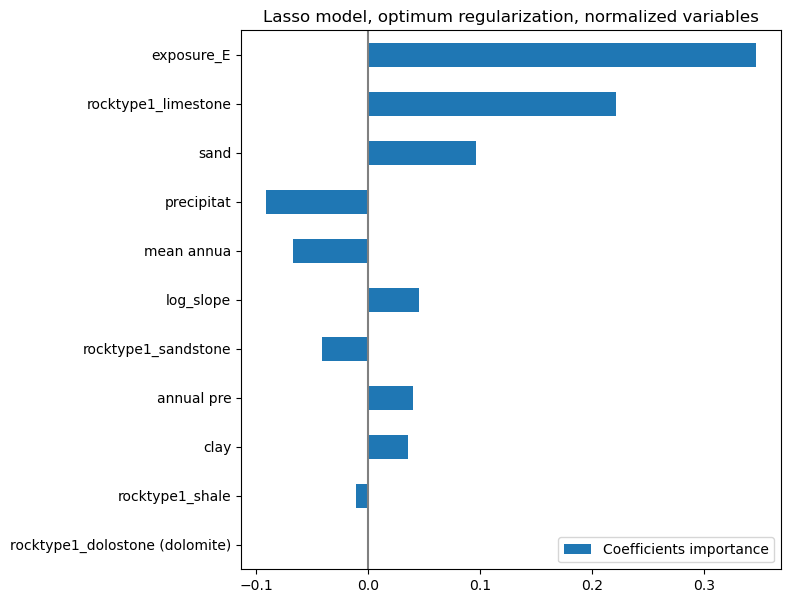

In [43]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.sort_values(by='Coefficients importance', key=np.abs, inplace=True)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

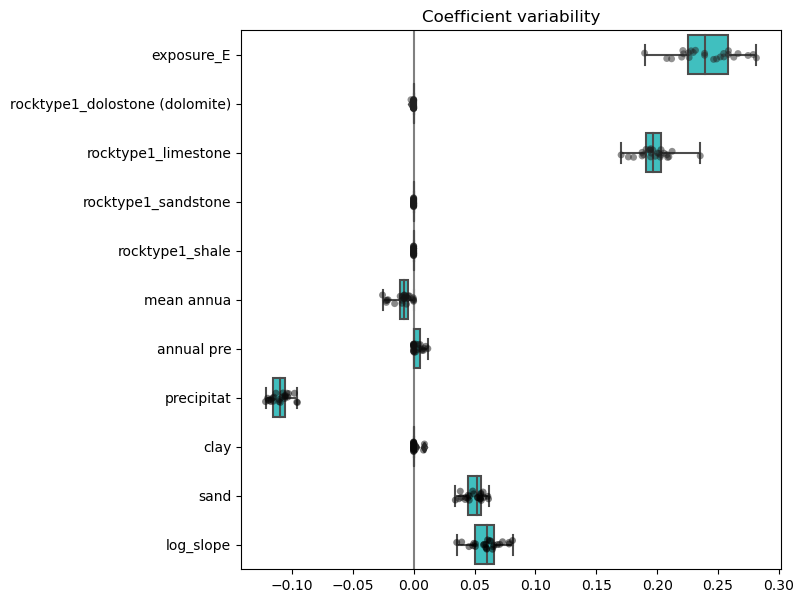

In [44]:
cv_model = cross_validate(
    model,
    X,
    Y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

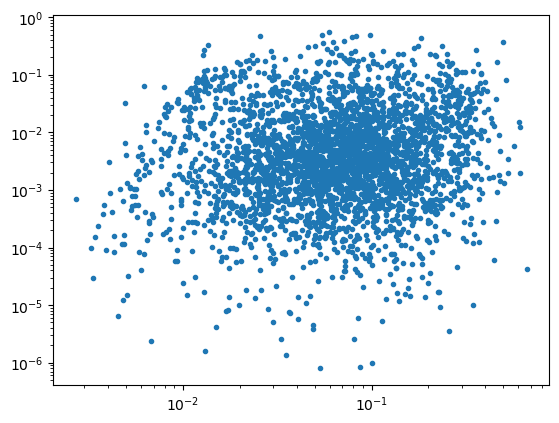

In [46]:
plt.loglog(X['median_slo'], Y, '.')